In [49]:
# Here we will train a machine learning model using our preprocessed population statistics and road network data
# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [50]:
# First, let's load our preprocessed data

dataSetName = 'NB'
census2016 = pd.read_csv(f'./processedData/processed_{dataSetName}_2016.csv')
census2021 = pd.read_csv(f'./processedData/processed_{dataSetName}_2021.csv')
networks = pd.read_csv(f'./processedData/networkCharacteristics.csv')


In [51]:
# We know what this data looks like from the other journal, but let's print things here for reference
census2016.head()

,GEO_NAME,% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),0 to 4 years,...,Total labour force population aged 15 years and over by occupation - National Occupational Classification (NOC) 2016 - 25% sample data,Total number of census families in private households - 100% data,Total population aged 15 years and over by work activity during the reference year - 25% sample data,Total visible minority population,Two-or-more person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,Aberdeen,7.3,38.2,0.0,0.0,25.0,85.0,120.0,25.0,25.0,...,370.0,250.0,720.0,0.0,5.0,0.0,75.0,20.0,410.0,285.0
1,Acadieville,7.4,36.4,0.0,0.0,15.0,80.0,95.0,31.6,25.0,...,325.0,240.0,595.0,10.0,5.0,0.0,70.0,21.5,380.0,245.0
2,Addington,7.1,44.6,0.0,0.0,15.0,70.0,85.0,11.8,10.0,...,320.0,210.0,585.0,0.0,10.0,10.0,90.0,28.1,375.0,215.0
3,Allardville,10.1,43.0,0.0,0.0,30.0,240.0,315.0,17.5,55.0,...,800.0,645.0,1785.0,0.0,20.0,0.0,215.0,26.9,1045.0,730.0
4,Alma,NaN,21.4,0.0,NaN,20.0,25.0,NaN,NaN,10.0,...,50.0,70.0,105.0,0.0,0.0,0.0,15.0,30.0,NaN,NaN


In [52]:
census2021.head()

,GEO_NAME,"% of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs",% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Legislative and senior management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),...,Total - Visible minority for the population in private households - 25% sample data,Total number of census families in private households - 100% data,Total visible minority population,Two-maintainer household,Two-or-more-person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,Aberdeen,NaN,5.9,35.3,0.0,0.0,0.0,90.0,110.0,10.0,...,875.0,255.0,0.0,200.0,15.0,10.0,40.0,9.6,460.0,265.0
1,Acadieville,NaN,6.8,50.8,0.0,0.0,0.0,90.0,100.0,16.0,...,745.0,250.0,0.0,190.0,10.0,0.0,70.0,20.9,400.0,265.0
2,Addington,NaN,9.7,38.7,0.0,0.0,0.0,80.0,100.0,14.0,...,695.0,225.0,0.0,150.0,5.0,0.0,75.0,20.8,380.0,235.0
3,Allardville,NaN,4.5,50.6,0.0,0.0,0.0,180.0,225.0,15.0,...,1935.0,630.0,10.0,390.0,30.0,0.0,195.0,21.3,1000.0,760.0
4,Alma,NaN,0.0,27.3,NaN,NaN,0.0,45.0,50.0,NaN,...,275.0,85.0,0.0,50.0,0.0,0.0,50.0,43.5,160.0,70.0


In [53]:
networks.head()

,Unnamed: 0,Node Connectivity,Betweenness Centrality,Average Node Degree,Top 10% BC
0,Aberdeen,1,"{1638571580: 0.0, 1638571707: 0.02531645569620...",4.550000,0.505883
1,Acadieville,1,"{1665424050: 0.0, 1665425717: 0.0, 1665427309:...",4.203390,0.506352
2,Addington,0,"{604124914: 0.1076792705080486, 1020806170: 0....",5.054902,0.162141
3,Alma,1,"{16878195: 0.4796404019037546, 857586389: 0.20...",4.063492,0.469240
4,Alnwick,1,"{1729459293: 0.0, 1729460255: 0.01059597042722...",4.518519,0.281422


In [54]:
# Note that the counts are different on our datasets. Let's take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
trimmed2021 = census2021[census2021['GEO_NAME'].isin(census2016['GEO_NAME'])]
trimmed2021.info()


<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 228
Columns: 263 entries, GEO_NAME to Without employment income
dtypes: float64(262), object(1)
memory usage: 449.6+ KB


In [55]:
# We have more entries here than in the `2016 data. Let's count the unique values
print(len(trimmed2021['GEO_NAME'].unique()))

218


In [56]:
# Lots of duplicates there. Let's check the 2016 data as well
print(len(census2016['GEO_NAME'].unique()))

234


In [57]:
# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016[census2016['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]
trimmed2016.shape

# As a last step before we are done, we need to sort the dataframes by the community name so that the
# data is in the same order for both datasets
trimmed2016 = trimmed2016.sort_values(by='GEO_NAME')
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')


In [58]:
# Now we can train our model. We will use the 2016 data as our X values and the 2021 data as our y values.
from sklearn.model_selection import train_test_split

X = trimmed2016.drop(columns=['GEO_NAME'])
y = trimmed2021['Population, 2021']

# Split the training data into training and validation sets
XTrain, XVal, yTrain, yVal = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=42)

In [59]:
# We will use a pipeline to preprocess our data
# All features here are numeric, so we will use a simple imputer to fill in missing values
# and a standard scaler to scale the data
numericTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
    ('scaler', StandardScaler())
])

# Setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericTransformer, X.columns)
    ]
)

In [60]:
# Now we can set up our model
# We'll use a random forest regressor
numberOfTrees = 100
regressor = RandomForestRegressor(n_estimators=numberOfTrees, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])


In [61]:
# Train the model
model.fit(XTrain, yTrain)
None

In [62]:
# Predict our values
yPred = model.predict(XVal)

# Calculate the root mean squared error
valRmse = root_mean_squared_error(yVal, yPred)
# Calculate the R^2 value
valR2 = r2_score(yVal, yPred)

print(f'Validation RMSE: {valRmse}')
print(f'Validation R^2: {valR2}')


Validation RMSE: 3130.4862466768204
Validation R^2: 0.8923172752879682


In [63]:
# R^2 and RMSE both look good, but let's compare with the mean of the training data
print(f'Mean of validation set: {round(yTrain.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmse / yTrain.mean() * 100, 2)}%')


Mean of validation set: 2562
Validation RMSE as a percentage of the mean: 122.18%


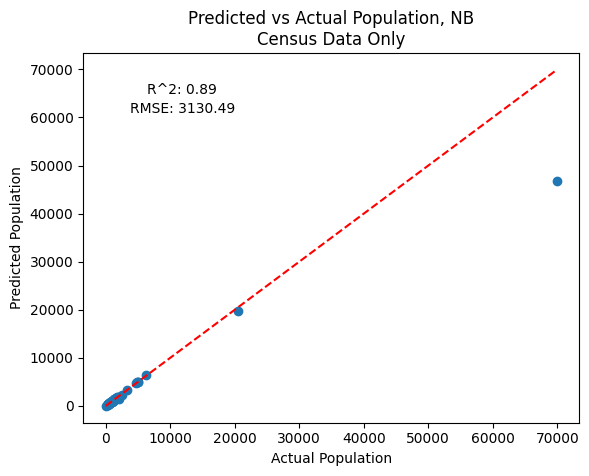

In [64]:
# Let's plot the predicted vs actual values
plt.scatter(yVal, yPred)
# Add a line for perfect correlation
plt.plot([y.min(), y.max()], [y.min(), y.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population, NB\nCensus Data Only')

# Let's also include the R^2 and RMSE in the plot
plt.text(0.2, 0.9, f'R^2: {round(valR2, 2)}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.2, 0.85, f'RMSE: {round(valRmse, 2)}', ha='center', va='center', transform=plt.gca().transAxes)

# As with the other plots, let's save things to our figures folder
plt.savefig(f'./figures/predicting_vs_actual_census_only_{dataSetName}.png')


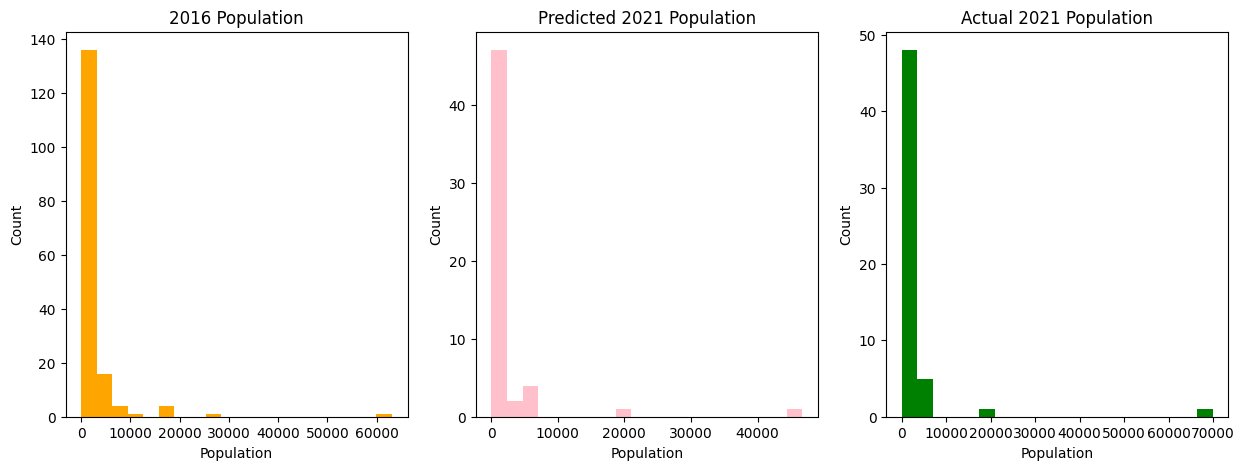

In [65]:
# Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
# as a set of subplots.
# This will let us see how the communities changed over time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
dataSets = [yTrain, yPred, yVal]
titles = ['2016 Population', 'Predicted 2021 Population', 'Actual 2021 Population']
colors = ['orange', 'pink', 'green']
for i in range(3):
    axs[i].hist(dataSets[i], bins=20, color = colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population')
    axs[i].set_ylabel('Count')

# Let's save the plot in our figures folder
plt.savefig(f'./figures/predictions_census_only_{dataSetName}.png')



In [66]:
# To explore the data further, let's look at the feature importances
importances = model.named_steps['regressor'].feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
print(importances[indices])

[2.56712987e-02 2.56156087e-02 2.24720238e-02 2.16973256e-02
 2.10687041e-02 2.03687684e-02 1.93480942e-02 1.72042437e-02
 1.70930933e-02 1.68347003e-02 1.65033176e-02 1.64755781e-02
 1.59778970e-02 1.59015176e-02 1.57074675e-02 1.53786233e-02
 1.52297373e-02 1.51137298e-02 1.46679858e-02 1.38119106e-02
 1.37478423e-02 1.37435416e-02 1.36482178e-02 1.33476169e-02
 1.19968939e-02 1.15383180e-02 1.13965654e-02 1.10869273e-02
 1.05931636e-02 1.05541810e-02 9.84026133e-03 9.82294867e-03
 9.62377424e-03 9.56314885e-03 9.48591098e-03 9.39586103e-03
 9.30982168e-03 9.29763738e-03 9.26126688e-03 9.24203390e-03
 9.14402360e-03 9.04497787e-03 9.04014919e-03 9.00967383e-03
 8.86185204e-03 8.59195029e-03 8.58610851e-03 8.57501765e-03
 8.57084464e-03 8.56020515e-03 8.52422250e-03 8.52215303e-03
 8.45539667e-03 8.34941099e-03 8.34852259e-03 8.31114345e-03
 8.28636981e-03 8.24528664e-03 8.03769595e-03 7.97838117e-03
 7.94371721e-03 7.94032644e-03 7.75141410e-03 7.73767649e-03
 7.62493616e-03 7.589780

Most important features:
Total - Income statistics in 2015 for two-or-more-person private households - 100% data: 0.025671298678095193
Total - Private households by number of persons per room - 25% sample data: 0.025615608654562846
30 to 34 years: 0.02247202384018464
One-census-family households: 0.021697325566080082
Total - Income statistics in 2015 for economic families in private households - 25% sample data: 0.021068704114675114
40 to 44 years: 0.020368768357102534
Population, 2011: 0.019348094232931937
Total - Population by Registered or Treaty Indian status for the population in private households - 25% sample data: 0.017204243734117716
Number of after-tax income recipients aged 15 years and over in private households - 25% sample data: 0.017093093339896056
Total - Citizenship for the population in private households - 25% sample data: 0.016834700349531214


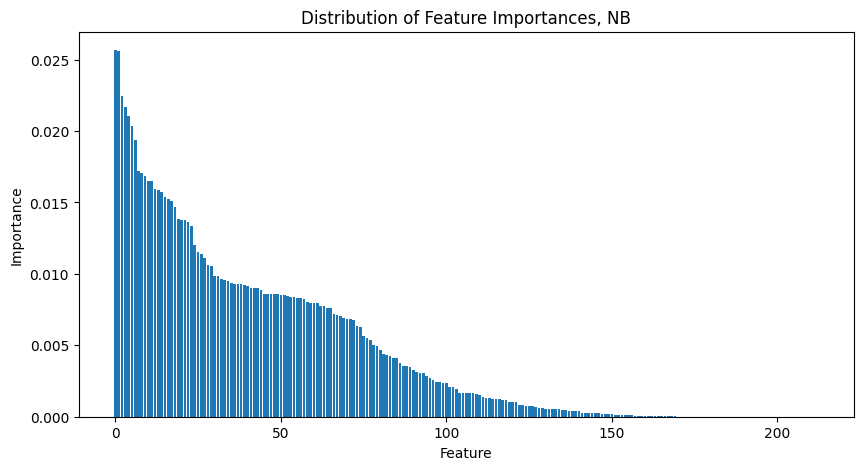

In [67]:
# Nothing stands out as any obvious high-importance outliers, but let's plot the importances
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances[indices])
plt.title(f'Distribution of Feature Importances, {dataSetName}')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.savefig(f'./figures/feature_importances_{dataSetName}.png')

# Let's have a look at the 10 most important features
print('Most important features:')
for i in range(10):
    print(f'{features[indices[i]]}: {importances[indices[i]]}')


In [68]:
# Let's train our model using the road network data and the 2021 population targets
# We imported the network data earlier, so we can use that directly
networks.head()

,Unnamed: 0,Node Connectivity,Betweenness Centrality,Average Node Degree,Top 10% BC
0,Aberdeen,1,"{1638571580: 0.0, 1638571707: 0.02531645569620...",4.550000,0.505883
1,Acadieville,1,"{1665424050: 0.0, 1665425717: 0.0, 1665427309:...",4.203390,0.506352
2,Addington,0,"{604124914: 0.1076792705080486, 1020806170: 0....",5.054902,0.162141
3,Alma,1,"{16878195: 0.4796404019037546, 857586389: 0.20...",4.063492,0.469240
4,Alnwick,1,"{1729459293: 0.0, 1729460255: 0.01059597042722...",4.518519,0.281422


In [69]:
# First we will need to rename the first column, and match the community names to the appropriate 2021 data
networks = networks.rename(columns={'Unnamed: 0': 'GEO_NAME'})
trimmedNetworks = networks[networks['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]

# Next we will trim the 2021 data to match the trimmed networks community names
populationForNetworks2021 = trimmed2021[trimmed2021['GEO_NAME'].isin(trimmedNetworks['GEO_NAME'])]
print(trimmedNetworks.shape)
print(populationForNetworks2021.shape)

# And then we need to reorder, as we did when working with the census data
populationForNetworks2021 = populationForNetworks2021.sort_values(by='GEO_NAME')
trimmedNetworks = trimmedNetworks.sort_values(by='GEO_NAME')

print(populationForNetworks2021.shape)
print(trimmedNetworks.shape)



(169, 5)
(169, 263)
(169, 263)
(169, 5)


In [70]:
# Now we can train our model. We will use the road network data as our X values and the 2021 data as our y values.
# From the road networks, we will use Node Connectivity, average node degree, and top 10% BC
XNetworks = trimmedNetworks.drop(columns=['GEO_NAME', 'Betweenness Centrality'])
yNetworks = populationForNetworks2021['Population, 2021']

# Split the training data into training and validation sets
XTrainNetworks, XValNetworks, yTrainNetworks, yValNetworks = train_test_split(XNetworks, yNetworks, test_size=0.2, random_state=42)

# We can use a similar pipeline to before, but we will need to define a new preprocessor for the network data
numericTransformerNetworks = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

preprocessorNetworks = ColumnTransformer(
    transformers=[
        ('num', numericTransformerNetworks, XNetworks.columns)
    ]
)

# Now we can set up our model
# We'll use a random forest regressor as before
networkTrees = 100
networkRegressor = RandomForestRegressor(n_estimators=networkTrees, random_state=42)
networkModel = Pipeline(steps=[
    ('preprocessor', preprocessorNetworks),
    ('regressor', networkRegressor)
])


In [71]:
# Now we can train our model
networkModel.fit(XTrainNetworks, yTrainNetworks)
None

In [76]:
# Predict our values
yPredNetworks = networkModel.predict(XValNetworks)

# Calculate the root mean squared error
valRmseNetworks = root_mean_squared_error(yValNetworks, yPredNetworks)
# Calculate the R^2 value
valR2Networks = r2_score(yValNetworks, yPredNetworks)

print(f'Validation RMSE: {valRmseNetworks}')
print(f'Validation R^2: {valR2Networks}')

Validation RMSE: 10534.14743307389
Validation R^2: -26.423116231687278


Mean of validation set: 3405
Validation RMSE as a percentage of the mean: 309.42%


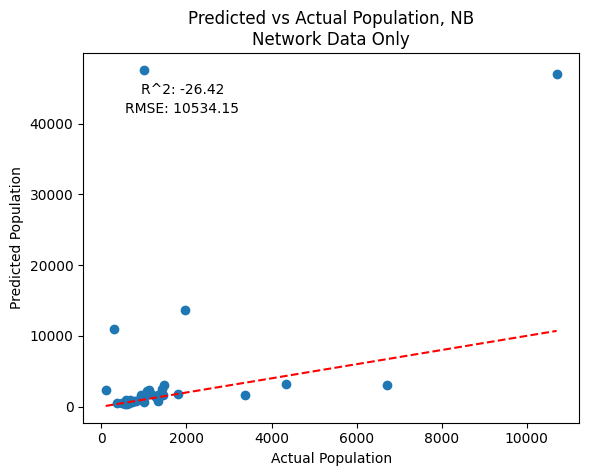

In [77]:
# Again, let's compare with the mean of the training data
print(f'Mean of validation set: {round(yTrainNetworks.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmseNetworks / yTrainNetworks.mean() * 100, 2)}%')

# Let's plot the predicted vs actual values
plt.scatter(yValNetworks, yPredNetworks)
# Add a line for perfect correlation
plt.plot([yValNetworks.min(), yValNetworks.max()], [yValNetworks.min(), yValNetworks.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population, NB\nNetwork Data Only')

# Let's also include the R^2 and RMSE in the plot
plt.text(0.2, 0.9, f'R^2: {round(valR2Networks, 2)}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.2, 0.85, f'RMSE: {round(valRmseNetworks, 2)}', ha='center', va='center', transform=plt.gca().transAxes)

plt.savefig('./figures/predicting_vs_actual_networks_only.png')

In [78]:
# Next, let's update the 2016 dataset with our road network values and train again.
# To get a proper comparison, we will need to compare only the communities that are present in the road network data
trimmed2016Networks = trimmed2016[trimmed2016['GEO_NAME'].isin(trimmedNetworks['GEO_NAME'])]

In [81]:
# Let's train a model with the same parameters as we did in the initial census training
Xtrim = trimmed2016Networks.drop(columns=['GEO_NAME'])
ytrim = trimmed2021[trimmed2021['GEO_NAME'].isin(trimmed2016Networks['GEO_NAME'])]['Population, 2021']

# Split the training data into training and validation sets
XTrainTrim, XValTrim, yTrainTrim, yValTrim = train_test_split(Xtrim, ytrim, test_size=0.2, random_state=42)

# We can use the same preprocessor and regressor as before
trimModel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Now we can train our model
trimModel.fit(XTrainTrim, yTrainTrim)

# Predict our values
yPredTrim = trimModel.predict(XValTrim)

# Calculate our statistics
valRmseTrim = root_mean_squared_error(yValTrim, yPredTrim)
valR2Trim = r2_score(yValTrim, yPredTrim)

print(f'Validation RMSE: {valRmseTrim}')
print(f'Validation R^2: {valR2Trim}')

Validation RMSE: 311.48684260759234
Validation R^2: 0.976022857035319


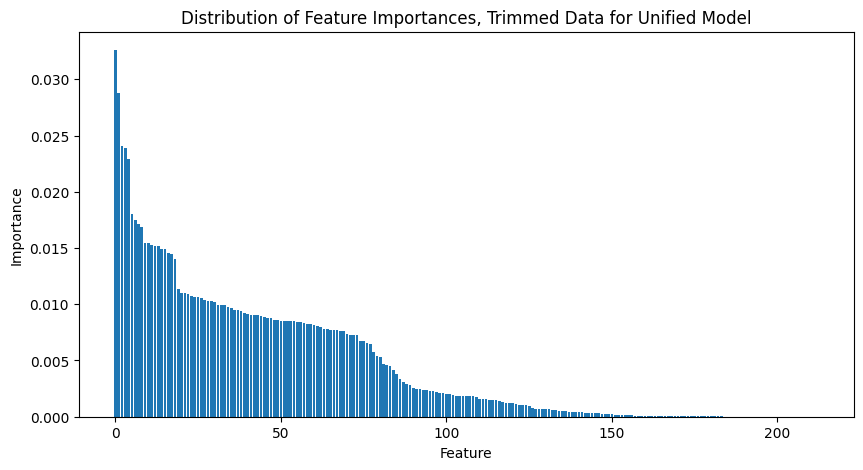

Most important features:
30 to 34 years: 0.03260485834962528
Total - Income statistics in 2015 for two-or-more-person private households - 100% data: 0.028745272893727226
Total - Private households by number of persons per room - 25% sample data: 0.024055860561789388
One-census-family households: 0.023924849436687552
85 years and over: 0.022880153207802338
Total - Major field of study - Classification of Instructional Programs (CIP) 2016 for the population aged 25 to 64 years in private households - 25% sample data: 0.01805376588128397
Number of persons in private households: 0.0174767557225832
Population, 2016: 0.017150750790606063
Total - Admission category and applicant type for the immigrant population in private households who landed between 1980 and 2016 - 25% sample data: 0.01686619918434289
55 to 59 years: 0.015459517723847094


In [82]:
# Let's also extract the 10 most important features
importancesTrim = trimModel.named_steps['regressor'].feature_importances_
featuresTrim = Xtrim.columns
indicesTrim = np.argsort(importancesTrim)[::-1]

# Let's plot the importances
plt.figure(figsize=(10, 5))
plt.bar(range(Xtrim.shape[1]), importancesTrim[indicesTrim])
plt.title('Distribution of Feature Importances, Trimmed Data for Unified Model')
plt.ylabel('Importance')
plt.xlabel('Feature')
# plt.savefig('./figures/feature_importances_trimmed.png')
plt.show()

# Print
print('Most important features:')
for i in range(10):
    print(f'{featuresTrim[indicesTrim[i]]}: {importancesTrim[indicesTrim[i]]}')

# We'll also save the top 5 features here as a list for later reference
baselineTopFive = list(featuresTrim[indicesTrim[:5]])

In [83]:
# Now we can assemble the dataset for the final test: census + road network
unifiedData = pd.merge(trimmed2016Networks, trimmedNetworks, on='GEO_NAME')
XUnified = unifiedData.drop(columns=['GEO_NAME', 'Betweenness Centrality'])
yUnified = populationForNetworks2021['Population, 2021']

# Split the training data into training and validation sets
XTrainUnified, XValUnified, yTrainUnified, yValUnified = train_test_split(XUnified, yUnified, test_size=0.2, random_state=42)

# Let's define a new preprocessor for the unified data
unifiedTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

unifiedPreprocessor = ColumnTransformer(
    transformers=[
        ('num', unifiedTransformer, XUnified.columns)
    ]
)

# Now we can set up our model
# We'll use a random forest regressor as before
unifiedTrees = 100
unifiedRegressor = RandomForestRegressor(n_estimators=networkTrees, random_state=42)
unifiedModel = Pipeline(steps=[
    ('preprocessor', unifiedPreprocessor),
    ('regressor', unifiedRegressor)
])

# Train the model
unifiedModel.fit(XTrainUnified, yTrainUnified)
None

Validation RMSE: 254.5546259010963
Validation R^2: 0.9839867307104848


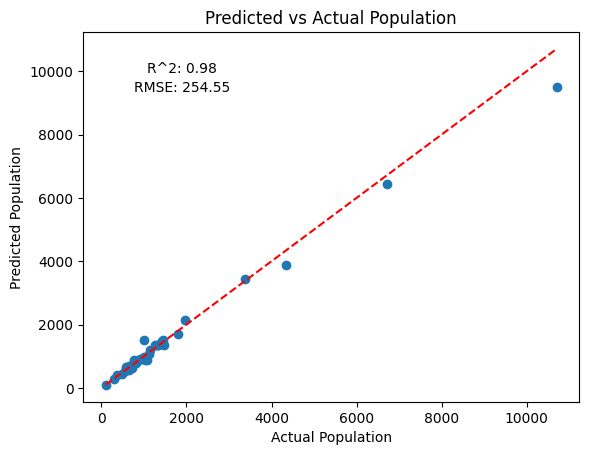

In [84]:
# Now we can do our final prediction
yPredUnified = unifiedModel.predict(XValUnified)

# Once again, we will get the statistics and plot the predicted vs actual values
valRmseUnified = root_mean_squared_error(yValUnified, yPredUnified)
valR2Unified = r2_score(yValUnified, yPredUnified)

print(f'Validation RMSE: {valRmseUnified}')
print(f'Validation R^2: {valR2Unified}')

# Let's plot the predicted vs actual values
plt.scatter(yValUnified, yPredUnified)
# Add a line for perfect correlation
plt.plot([yValUnified.min(), yValUnified.max()], [yValUnified.min(), yValUnified.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population')

# Once again we will include the R^2 and RMSE values in the plot
plt.text(0.2, 0.9, f'R^2: {round(valR2Unified, 2)}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.2, 0.85, f'RMSE: {round(valRmseUnified, 2)}', ha='center', va='center', transform=plt.gca().transAxes)

plt.savefig(f'./figures/predicting_vs_actual_unified_{dataSetName}.png')


In [85]:
# Once again, we will look at the top 10 most important features
importancesUnified = unifiedModel.named_steps['regressor'].feature_importances_
featuresUnified = XUnified.columns
indicesUnified = np.argsort(importancesUnified)[::-1]

for i in range(10):
    print(f'{featuresUnified[indicesUnified[i]]}: {importancesUnified[indicesUnified[i]]}')

2 household maintainers: 0.02790593593393208
Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data: 0.027855677351964852
Total - Owner households in non-farm, non-reserve private dwellings - 25% sample data: 0.02698102665186255
In the labour force: 0.025656213010890702
Self-employed: 0.024964718673413648
85 to 89 years: 0.023331386453388465
In the fourth decile: 0.022410458902425285
45 to 54 years: 0.020867815382232566
Number of government transfers recipients aged 15 years and over in private households - 100% data: 0.019702981695942045
Total - Private households by tenure - 25% sample data: 0.016985804536766926


In [86]:
# It's interesting to note that the top 10 features here are different, when we've only added three columns.
# As an experiment, let's do one more iteration. We will further trim the data set to contain 
# only the original top 5 features and the road network data,
# and train a model again to see our results.

# We can use the baseline top 5 we saved earlier
# Let's add our network characteristics to the top 5 so we can trim all at once
experimentFeatures = baselineTopFive + (['Node Connectivity', 'Average Node Degree', 'Top 10% BC'])
XExperiment = unifiedData[experimentFeatures]
yExperiment = populationForNetworks2021['Population, 2021']

XTrainExperiment, XValExperiment, yTrainExperiment, yValExperiment = train_test_split(XExperiment, yExperiment, test_size=0.2, random_state=42)

# Since the shape of X has changed, we will need a new column transformer
# The unified transformer should still work

experimentPreprocessor = ColumnTransformer(
    transformers=[
        ('num', unifiedTransformer, XExperiment.columns)
    ]
)
experimentModel = Pipeline(steps=[
    ('preprocessor', experimentPreprocessor),
    ('regressor', unifiedRegressor)
])

experimentModel.fit(XTrainExperiment, yTrainExperiment)
None

In [89]:
# Let's see how our experiment turned out
yPredExperiment = experimentModel.predict(XValExperiment)

valRmseExperiment = root_mean_squared_error(yValExperiment, yPredExperiment)
valR2Experiment = r2_score(yValExperiment, yPredExperiment)

print(f'Validation RMSE: {valRmseExperiment}')
print(f'Validation R^2: {valR2Experiment}')


Validation RMSE: 300.13868445907394
Validation R^2: 0.9777381132529575


In [90]:
# Let's see if any of the network characteristics became important
importancesExperiment = experimentModel.named_steps['regressor'].feature_importances_
featuresExperiment = XExperiment.columns
indicesExperiment = np.argsort(importancesExperiment)[::-1]

# Since we only have 8 features, we can list them all
for i in range(8):
    print(f'{featuresExperiment[indicesExperiment[i]]}: {importancesExperiment[indicesExperiment[i]]}')

Total - Private households by number of persons per room - 25% sample data: 0.23625393645236725
Total - Income statistics in 2015 for two-or-more-person private households - 100% data: 0.22818248196443497
85 years and over: 0.18813922717476042
One-census-family households: 0.179406698102573
30 to 34 years: 0.15369778838567114
Top 10% BC: 0.013496168875832529
Average Node Degree: 0.0007706504293461166
Node Connectivity: 5.304861501460306e-05


Only the betweenness centrality had much impact, but it looks like the model performance did improve slightly with the  addition of the road network characteristics when using the full dataset. However, it would be reasonable to conclude here that the census data is so effective at predicting population change that the road network data is superfluous. It may be worth looking at in some more detail when less robust population data is available, but let's leave it out of the work exploring the other research questions for now. 